<a href="https://colab.research.google.com/github/yashshetty1409/TumorDetection/blob/main/DLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io
from keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/dataset/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/dataset/Testing', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 74/74 [00:17<00:00,  4.18it/s]


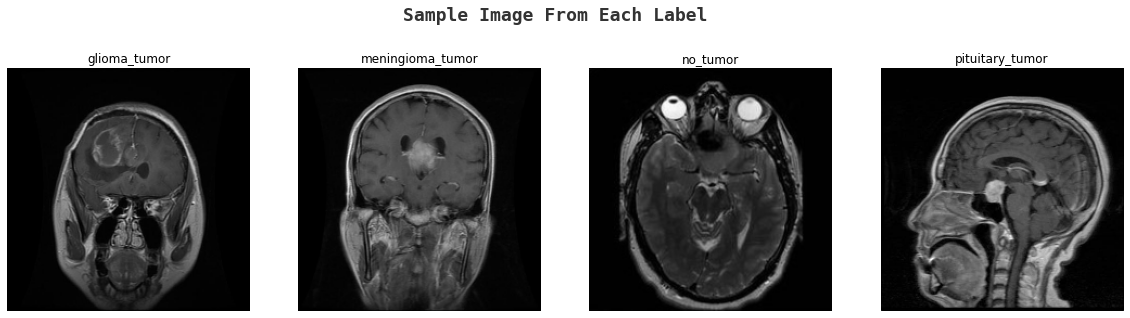

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=14)

In [ ]:
X_train.shape


(2870, 224, 224, 3)

In [ ]:
X_test.shape

(394, 224, 224, 3)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=14)

In [ ]:
X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.
X_test = np.array(X_test) / 255.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range=0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)  

datagen.fit(X_train)

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/cnnbestmodel.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=1)

In [ ]:
model_cnn = Sequential()

model_cnn.add(Conv2D(64, (3, 3), padding='same',input_shape=(image_size,image_size,3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Conv2D(64, (3, 3))) 
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35))

model_cnn.add(Conv2D(64, (3, 3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization()) 

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2))) 
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.35)) 

model_cnn.add(Conv2D(64, (3, 3), padding='same')) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())

model_cnn.add(Flatten()) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(Dense(512)) 
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dense(4)) 
model_cnn.add(Activation('softmax'))


In [ ]:
model_cnn.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [ ]:
history = model_cnn.fit(X_train, y_train,validation_split=0.1, verbose=1, batch_size = 32, validation_data = (X_val, y_val),
                     epochs = 20, callbacks =[tensorboard,checkpoint,reduce_lr])

Epoch 1/20
73/73 [==============================] - ETA: 0s - loss: 0.9426 - accuracy: 0.7052
Epoch 1: val_accuracy improved from -inf to 0.26255, saving model to /content/drive/MyDrive/cnnbestmodel.h5
73/73 [==============================] - 89s 1s/step - loss: 0.9426 - accuracy: 0.7052 - val_loss: 8.3243 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.8253
Epoch 2: val_accuracy improved from 0.26255 to 0.29730, saving model to /content/drive/MyDrive/cnnbestmodel.h5
73/73 [==============================] - 43s 596ms/step - loss: 0.4470 - accuracy: 0.8253 - val_loss: 18.0307 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8851
Epoch 3: val_accuracy did not improve from 0.29730
73/73 [==============================] - 35s 484ms/step - loss: 0.3230 - accuracy: 0.8851 - val_loss: 15.6348 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 4/20
73/

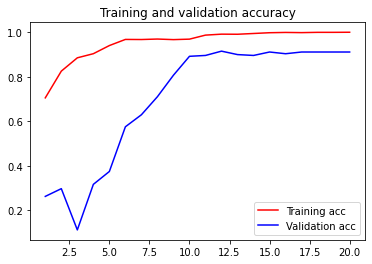

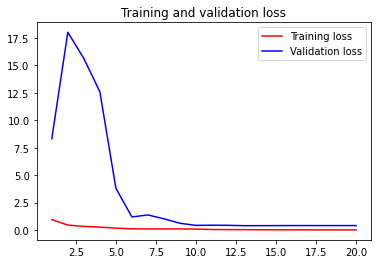

In [ ]:
model_cnn.save('cnn_model.h5')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
pred = model_cnn.predict(X_test)
pred = np.argmax(pred,axis=1)
ground = np.argmax(y_test,axis=1)


In [ ]:
accuracy = np.sum(pred==ground)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))


Accuracy on testing dataset: 70.81%


In [ ]:
from tensorflow import keras
model_cnn = keras.models.load_model('cnn_model.h5')

In [ ]:
model_cnn.evaluate(X_train, y_train)


81/81 [==============================] - 7s 78ms/step - loss: 0.0305 - accuracy: 0.9915


[0.030516989529132843, 0.9914827942848206]

In [ ]:
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.95      0.19      0.32       100
           1       0.74      0.89      0.81       115
           2       0.64      0.98      0.77       105
           3       0.84      0.84      0.84        74

    accuracy                           0.73       394
   macro avg       0.79      0.72      0.68       394
weighted avg       0.78      0.73      0.68       394



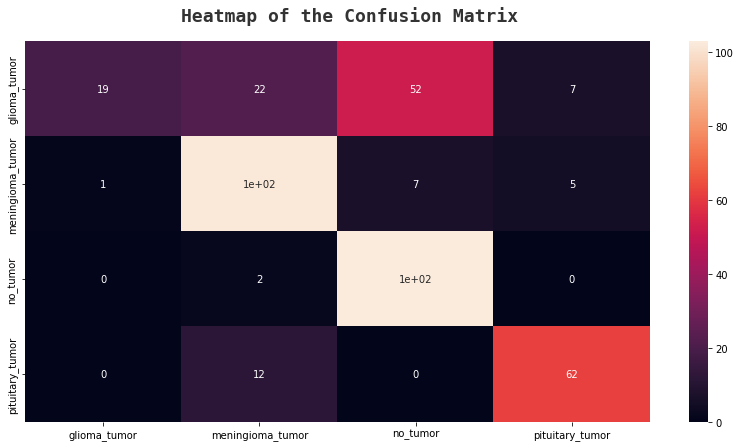

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(ground,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
directory = '/content/drive/MyDrive/dataset/Training'
directory2 = '/content/drive/MyDrive/dataset/Testing'

In [ ]:
File=[]
for file in os.listdir(directory):
    File+=[file]
print(File)

['pituitary_tumor', 'glioma_tumor', 'no_tumor', 'meningioma_tumor']


In [ ]:
dataset=[]
mapping={'no_tumor':0, 'pituitary_tumor':1, 'meningioma_tumor':2, 'glioma_tumor':3}
count=0

for file in os.listdir(directory):
    path=os.path.join(directory,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(150,150))
        image=img_to_array(image)
        image=image/255.0
        dataset.append([image,count])     
    count=count+1

In [ ]:
testset=[]
mapping={'no_tumor':0, 'pituitary_tumor':1, 'meningioma_tumor':2, 'glioma_tumor':3}
count=0

for file in os.listdir(directory2):
    path=os.path.join(directory2,file)
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(150,150))
        image=img_to_array(image)
        image=image/255.0
        testset.append([image,count])         
    count=count+1

In [ ]:
data,labels0=zip(*dataset)
test,testlabels0=zip(*testset)

In [ ]:
labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)
print(data.shape)
print(labels.shape)

(2870, 150, 150, 3)
(2870, 4)


In [ ]:
testlabels1=to_categorical(testlabels0)
test=np.array(test)
testlabels=np.array(testlabels1)
print(test.shape)
print(testlabels.shape)

(394, 150, 150, 3)
(394, 4)


In [ ]:
data2=data.reshape(-1,150,150,3)
test2=test.reshape(-1,150,150,3)

In [ ]:
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

In [ ]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(150,150,3),include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

74850304/74836368 [==============================] - 2s 0us/step


In [ ]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(4, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

mc = ModelCheckpoint(filepath="/content/drive/MyDrive/bestmodel.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),callbacks=[es,mc],epochs=20)

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.8997 - accuracy: 0.6372
Epoch 1: val_accuracy improved from -inf to 0.81359, saving model to /content/drive/MyDrive/bestmodel.h5
72/72 [==============================] - 57s 470ms/step - loss: 0.8997 - accuracy: 0.6372 - val_loss: 0.4805 - val_accuracy: 0.8136
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.7809
Epoch 2: val_accuracy did not improve from 0.81359
72/72 [==============================] - 21s 289ms/step - loss: 0.5522 - accuracy: 0.7809 - val_loss: 0.5157 - val_accuracy: 0.8066
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8206
Epoch 3: val_accuracy improved from 0.81359 to 0.82056, saving model to /content/drive/MyDrive/bestmodel.h5
72/72 [==============================] - 24s 331ms/step - loss: 0.4776 - accuracy: 0.8206 - val_loss: 0.5066 - val_accuracy: 0.8206
Epoch 4/20
72/72 [==============================] - ETA: 0

In [ ]:
model.save('/content/drive/MyDrive/besttlmodel.h5')

In [ ]:
y_pred=model.predict(testx)
pred=np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       157
           1       0.99      0.81      0.89       170
           2       0.91      0.90      0.91        81
           3       0.86      0.85      0.85       166

    accuracy                           0.88       574
   macro avg       0.89      0.89      0.88       574
weighted avg       0.89      0.88      0.88       574



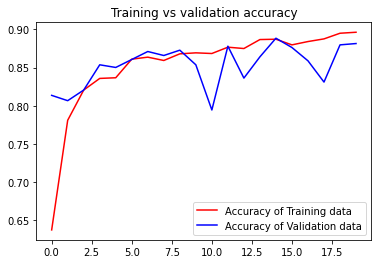

<Figure size 432x288 with 0 Axes>

In [ ]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

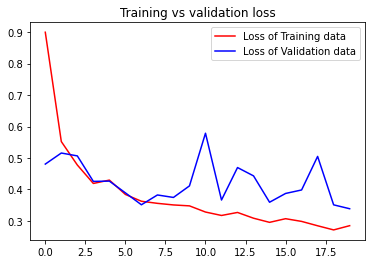

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
pred = model.predict(testx)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(testy,axis=1)

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 88.15%


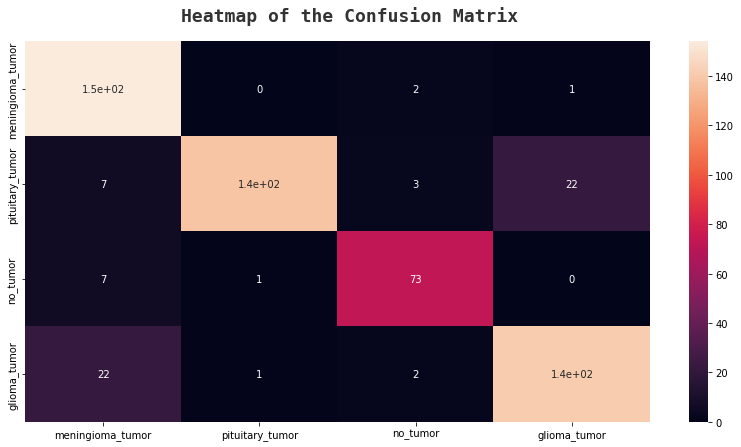

In [ ]:
labels = ['meningioma_tumor', 'pituitary_tumor','no_tumor','glioma_tumor']
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(ground,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/besttlmodel.h5')

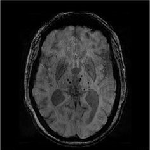

In [ ]:
load_img("/content/drive/MyDrive/dataset/Testing/no_tumor/image(29).jpg",target_size=(150,150))

In [ ]:
image=load_img("/content/drive/MyDrive/dataset/Testing/no_tumor/image(29).jpg",target_size=(150,150))
image=img_to_array(image) 
image=image/255.0
prediction_image=np.array(image)
prediction_image= np.expand_dims(image, axis=0)

In [ ]:
reverse_mapping={0:'meningioma_tumor', 1:'pituitary_tumor', 2:'no_tumor', 3:'glioma_tumor'}

def mapper(value):
    return reverse_mapping[value]

prediction=model.predict(prediction_image)
value=np.argmax(prediction)
move_name=mapper(value)
print("Prediction is {}.".format(move_name))